In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
from tqdm import tqdm

In [2]:
args={}
kwargs={}

args['batch_size']=1000
args['test_batch_size']=1000

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/content/data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/content/data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 38914103.32it/s]


Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1066504.32it/s]


Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8087021.50it/s]


Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11400675.50it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [4]:
for i, b in enumerate(test_loader):
  if i > 0:
    break
  print(len(b))
  print(b[0].shape)
  print(b[1].shape)

2
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


In [5]:
class Net(nn.Module):
    def __init__(self, args=None):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 1, 28, 28 -> # 10, 24, 24
        self.conv1_max_pool = nn.MaxPool2d(2) # 10, 12, 12
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 10, 12, 12 -> 20, 8, 8 = 1280
        self.conv2_drop = nn.Dropout2d(inplace=True) # 20, 8, 8
        self.conv2_max_pool = nn.MaxPool2d(2) # 20, 4, 4 = 320
        self.fc1 = nn.Linear(320, 160)
        self.fc2 = nn.Linear(160, 10)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()

        model = [
            self.conv1,
            self.conv1_max_pool,
            self.relu
        ]

        model += [
            self.conv2,
            self.conv2_drop,
            self.conv2_max_pool,
            self.relu
        ]

        model += [
            self.flatten,
            self.fc1,
            self.relu,
            self.fc2,
            nn.LogSoftmax(dim=1)
        ]

        self.model = nn.Sequential(*model)
        self.set_args(args)

    def forward(self, x):
      return self.model(x)

    def set_args(self, user_args):
      args={}
      args['batch_size']=1000
      args['test_batch_size']=1000
      args['epochs']=20
      args['lr']=0.01
      args['momentum']=0.5

      args['seed']=42
      args['log_interval']=10
      args['cuda']=True if torch.cuda.is_available() else False
      args['device'] = "cuda" if args['cuda'] else "cpu"

      args['optimizer'] = torch.optim.SGD(self.model.parameters(), lr=args['lr'], momentum=args['momentum'])
      args['loss_function'] = nn.NLLLoss()

      if user_args != None:
        args.update(user_args)
      self.args = args

In [6]:
def train_epoch(model, args):
  loader = args['train_loader']
  optimizer = args['optimizer']
  loss_function = args['loss_function']

  losses = []

  model.train()
  for i, (tensor, target) in tqdm(enumerate(loader)):
    optimizer.zero_grad()
    tensor = tensor.to(args['device'])
    target = target.to(args['device'])

    prediction = model(tensor)
    loss = loss_function(prediction, target)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

  return losses

def train(model):
  args = model.args
  epochs = args['epochs']
  model.to(args['device'])

  losses = []
  for epoch in range(epochs):
    loss_epoch = train_epoch(model, args)
    losses.append(np.mean(loss_epoch))
    print('{}: {}'.format(epoch, losses[-1]))

def test(model):
  losses = []
  model.eval()
  args = model.args
  loss_function = args['loss_function']
  loader = args['test_loader']

  acc_numerator = 0
  acc_denumerator = len(loader.dataset)

  model.to(args['device'])
  for tensor, target in loader:
    tensor = tensor.to(args['device'])
    target = target.to(args['device'])

    prediction = model(tensor)
    pred_argmax = prediction.argmax(dim=1)

    # print(pred_argmax.shape, target.shape)
    num_corrects = torch.sum((pred_argmax == target))
    acc_numerator += num_corrects

    loss = loss_function(prediction, target)

    losses.append(loss.item())

  print('Avg loss: {}, Acc: {}'.format(np.mean(losses), (acc_numerator / acc_denumerator)))

In [7]:
mynet = Net({'train_loader': train_loader, 'test_loader': test_loader})
mynet.args

{'batch_size': 1000,
 'test_batch_size': 1000,
 'epochs': 20,
 'lr': 0.01,
 'momentum': 0.5,
 'seed': 42,
 'log_interval': 10,
 'cuda': True,
 'device': 'cuda',
 'optimizer': SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0.5
     nesterov: False
     weight_decay: 0
 ),
 'loss_function': NLLLoss(),
 'train_loader': <torch.utils.data.dataloader.DataLoader at 0x7d224f646620>,
 'test_loader': <torch.utils.data.dataloader.DataLoader at 0x7d21727260b0>}

In [8]:
train(mynet)

60it [00:14,  4.11it/s]


0: 2.1959759891033173


60it [00:13,  4.50it/s]


1: 1.268475236495336


60it [00:13,  4.51it/s]


2: 0.5826602851351103


60it [00:12,  4.65it/s]


3: 0.4685013984640439


60it [00:12,  4.67it/s]


4: 0.4146224558353424


60it [00:12,  4.68it/s]


5: 0.37591734329859416


60it [00:13,  4.49it/s]


6: 0.34798093835512794


60it [00:12,  4.69it/s]


7: 0.32474618951479595


60it [00:13,  4.38it/s]


8: 0.306671587874492


60it [00:13,  4.36it/s]


9: 0.2888836286962032


60it [00:12,  4.66it/s]


10: 0.2760923609137535


60it [00:12,  4.71it/s]


11: 0.26280761932333313


60it [00:12,  4.68it/s]


12: 0.24965440680583317


60it [00:12,  4.64it/s]


13: 0.24131949966152508


60it [00:12,  4.63it/s]


14: 0.22893462479114532


60it [00:13,  4.50it/s]


15: 0.2239398201306661


60it [00:13,  4.44it/s]


16: 0.21385047882795333


60it [00:13,  4.55it/s]


17: 0.20574635763963064


60it [00:13,  4.45it/s]


18: 0.20063372974594434


60it [00:13,  4.41it/s]

19: 0.19339629312356313


In [9]:
test(mynet)

Avg loss: 0.1209392711520195, Acc: 0.963699996471405


In [10]:
import matplotlib.pyplot as plt

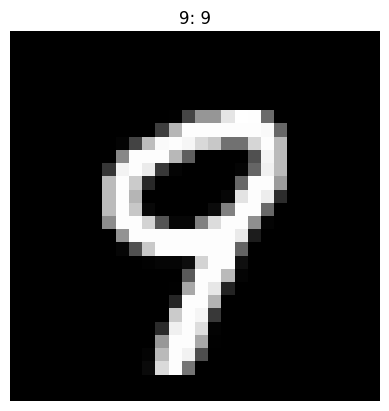

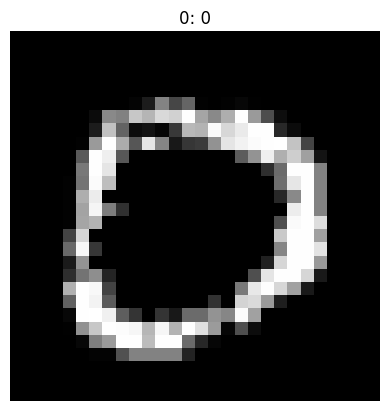

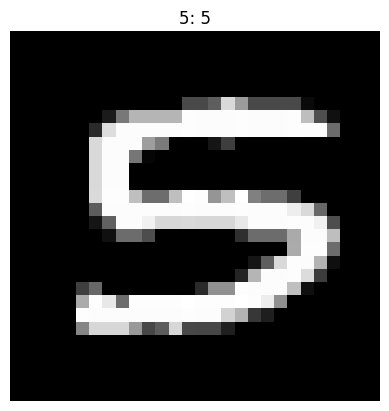

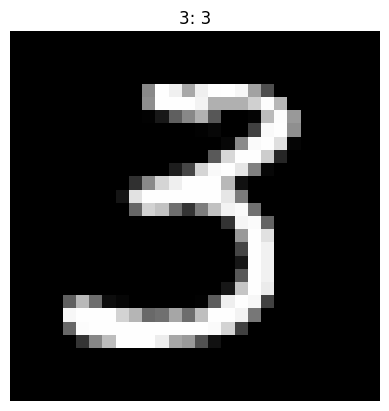

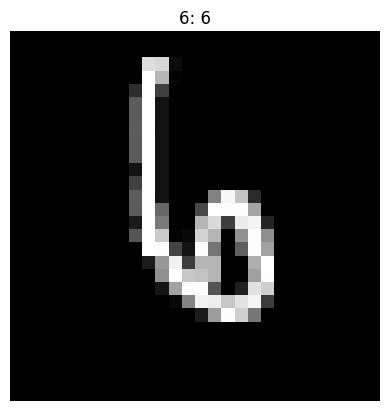

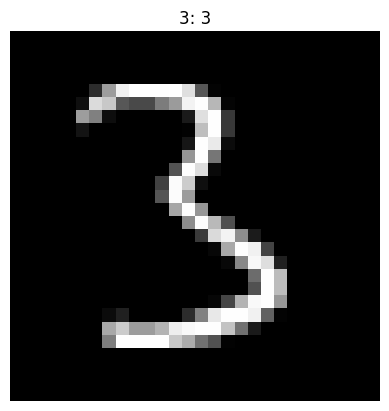

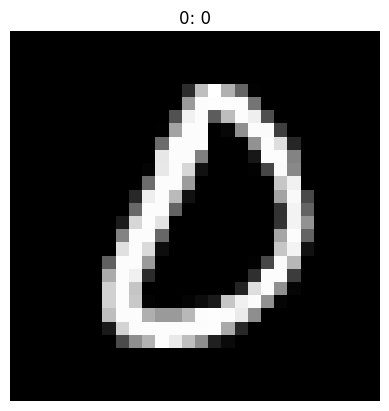

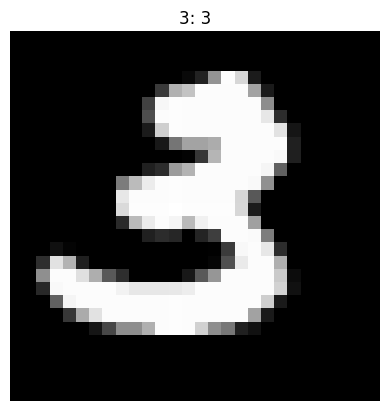

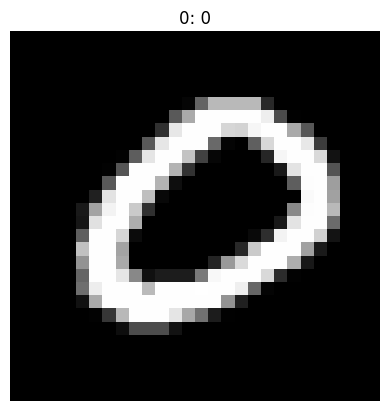

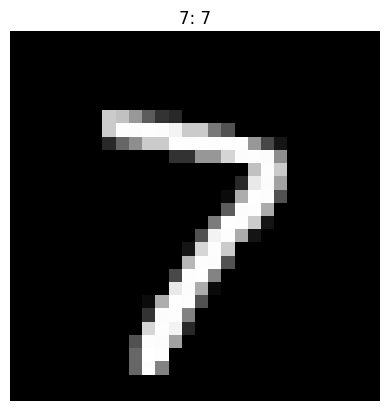

In [11]:
for i, (tensor, target) in enumerate(test_loader):
  if i > 100:
    break
  tensor = tensor.to(mynet.args['device'])
  prediction = mynet(tensor)

  image = tensor[0].squeeze(0)
  image_prediction = prediction[0].argmax()
  label = target[0]

  image_np = image.cpu().numpy()
  plt.imshow(image_np, cmap="gray")
  plt.title("{}: {}".format(label, image_prediction))
  plt.axis('off')
  plt.show()
